In [1]:
import os, sys, nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

c:\Users\yeget\Predicting-Price-Moves-with-News-Sentiment\notebooks


In [4]:
import scripts
from scripts.utility import format_date

In [5]:
sns.set_theme()

In [6]:
# Downloading nltk resources for performing NLP and sentiment analysis
nltk.download([
    "vader_lexicon",
    "punkt_tab",
])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yeget\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yeget\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
BASE_PATH = "../data/stock_data/"
NEWS_BASE_PATH = "../data/raw"
NEWS_DATA_PATH = os.path.join(NEWS_BASE_PATH , 'raw_analyst_ratings.csv')
APPL_PATH = os.path.join(BASE_PATH, "AAPL.csv")
AMZN_PATH = os.path.join(BASE_PATH, "AMZN.csv")
GOOG_PATH = os.path.join(BASE_PATH, "GOOG.csv")
META_PATH = os.path.join(BASE_PATH, "META.csv")
MSFT_PATH = os.path.join(BASE_PATH, "MSFT.csv")
NVDA_PATH = os.path.join(BASE_PATH, "NVDA.csv")

## load and prep data

In [9]:
# load the news data
news_df = pd.read_csv(NEWS_DATA_PATH , index_col=False)

# remove the index column
news_df = news_df.drop(columns=['Unnamed: 0'])

# convert the date into a pd.DateTime object
news_df['date'] = pd.to_datetime(news_df['date'] , utc=True , format="mixed")

# format the date to help with the matching
news_df['date'] = news_df['date'].apply(format_date)

## Let us load and prepare the financial(stock) data
For the sake of simplicity and to avoid downloading financial data again when ever this experiment file is run, I will be using the predownloaded yfinance data provided by Nova Finanacial Solutions.

I will load the data for individual tickers into individual variables and also combine them into one big dataframe incase it is needed in future cells and during that I will update the formats of the dates also

In [11]:
# read the historical datas into separate variables
appl_df = pd.read_csv(APPL_PATH)
amzn_df = pd.read_csv(AMZN_PATH)
goog_df = pd.read_csv(GOOG_PATH)
meta_df = pd.read_csv(META_PATH)
msft_df = pd.read_csv(MSFT_PATH)
nvda_df = pd.read_csv(NVDA_PATH)

# create lists: one that holds the symbol of the stock and another that holds the dataframe for the stock
tickers = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]
dataframes = [appl_df, amzn_df, goog_df, meta_df, msft_df, nvda_df]
# loop through the lists and create a single datframe from the dataframes and also format the dates
combined_df = pd.DataFrame()
for ticker, dataframe in zip(tickers, dataframes):
    # add the ticker info
    dataframe['Symbol'] = ticker

    # format the dates
    dataframe['date'] = pd.to_datetime(dataframe['Date'])
    dataframe['date'] = dataframe['date'].apply(format_date)

    # order the data by the date
    dataframe = dataframe.sort_values(by="date" , ascending=True)

    combined_df = pd.concat([combined_df, dataframe])

##  Find the average sentiment of news on a given date

## Let us find the sentiment of every news headline

In [12]:
# let us initialize NLTK's pre-trained sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [13]:
# apply the sentiment analyzer to obtain the sentiment and intensity of the sentiment
news_df['sentiment'] = news_df['headline'].apply(lambda headline: sentiment_analyzer.polarity_scores(headline)["compound"])

## Now let us select the news that belongs to the different stocks

In [14]:
# Dictionary to hold news related to each stock symbol
stock_news = {}

# variable for tracking the amount of news collected to do a check that none are left behind
total_headlines = 0

# Filter news for each stock symbol
for ticker, df in zip(tickers, dataframes):
    stock_news[ticker] = news_df[news_df["stock"].str.lower() == ticker.lower()]
    total_headlines += stock_news[ticker].shape[0]

In [15]:
# to makee sure no news headline is lost during the filtering
total_headlines - news_df.shape[0]

-1402264

## The data we have for each individual stock isn't enough to make a meaning full relationship with the rise and fall of our stocks because we will have small samples. Instead using that only let us create grouping for everyone of them and also use the general sentiment of the news(regardless of for which stock the news was published for)

In [16]:
# dictionary for holdin the data for every ticker
stock_news_sentiment = {}

# Filter news for each stock symbol
for stock in stock_news:
    data = stock_news[stock]
    stock_news_sentiment[stock] = data.groupby(by="date").agg(
    mean_sentiment = ("sentiment" , "mean"),
    num_publications = ("headline" , "size")
)

In [17]:
# group all the news by date and find the average sentiments 
news_date_grouping = news_df.groupby(by="date").agg(
    mean_sentiment = ("sentiment" , "mean"),
    num_publications = ("headline" , "size")
)

##  Find the daily return of every stock
## Let us find the daily returns of our stocks in percentage, i.e the percentage change from day to day

In [18]:
# for all the data calculate the daily return
for ticker, dataframe in zip(tickers, dataframes):
    dataframe['daily_return'] = dataframe['Close'].pct_change()

## Now let us match dates for both of the dataframes(news and stock) and put them in one dataframe
## First let us merge the stock info with all the news

In [19]:
all_news_merge = {}
for ticker, dataframe in zip(tickers, dataframes):
    all_news_merge[ticker] = pd.merge(dataframe, news_date_grouping, on="date", how='inner')

## Now let us merge the stock info with news that talk about the respective stock only

In [20]:
respective_news_merge = {}
for ticker, dataframe in zip(tickers, dataframes):
    news_data = stock_news_sentiment[ticker] 
    respective_news_merge[ticker] = pd.merge(dataframe, news_data, on="date", how='inner')

##  Now let us perform correlation analysis
## First let us check the correlation between all the news(related and unreated to respective stocks) and the daily returns of the stock

In [21]:
all_news_correlation = {}

for stock in all_news_merge:
    data = all_news_merge[stock]
    # Calculate Pearson correlation
    pearson_corr = data['mean_sentiment'].corr(data['daily_return'], method='pearson')

    # Calculate Kendall’s Tau correlation
    kendall_corr = data['mean_sentiment'].corr(data['daily_return'], method='kendall')

    # Calculate Spearman’s Rank correlation
    spearman_corr = data['mean_sentiment'].corr(data['daily_return'], method='spearman')

    # add to the dictionary
    all_news_correlation[stock] = {
        "pearson" : pearson_corr,
        "kendall" : kendall_corr,
        "spearman" : spearman_corr
    }

    print(f"{stock} correlations with news => Pearson({pearson_corr}), Kendall({kendall_corr}), Spearman({spearman_corr})")

AAPL correlations with news => Pearson(0.1447811140312), Kendall(0.07049371078498379), Spearman(0.10540642234737865)
AMZN correlations with news => Pearson(0.08223958354879742), Kendall(0.07866188304960688), Spearman(0.11600400721379409)
GOOG correlations with news => Pearson(0.12544418066803892), Kendall(0.08022946621491456), Spearman(0.11966110798270979)
META correlations with news => Pearson(0.14814947884914953), Kendall(0.0837899049121844), Spearman(0.12515876365662404)
MSFT correlations with news => Pearson(0.12240597924517023), Kendall(0.07644423062889062), Spearman(0.11323520476732152)
NVDA correlations with news => Pearson(0.11462703129055785), Kendall(0.09057873829995874), Spearman(0.13300558424759865)


## The correlations between news sentiment and daily returns for each stock (AAPL, AMZN, GOOG, META, MSFT, NVDA, TSLA) are generally weak across all three correlation metrics: Pearson, Kendall’s Tau, and Spearman’s Rank.

Pearson Correlation: Values range from ~0.08 to ~0.15, indicating a weak linear relationship between news sentiment and daily returns.
Kendall’s Tau & Spearman’s Rank: These non-parametric measures also show weak correlations, suggesting that even the ordinal relationships (rank-based) between news sentiment and returns are not strong.
The weak correlation values suggest that, for these stocks, news sentiment may not be the sole predictor of daily returns. This could be due to various factors such as market efficiency, where stock prices quickly incorporate public information, or the multifaceted nature of stock prices, which may be influenced by other factors beyond sentiment captured by the news.

In summary, while there is a positive but weak association between news sentiment and stock returns, it is unlikely to be a reliable standalone predictor for short-term price movements in these stocks.

## Okay now let us see the relation the daily return has with the news of the respective stock, the test before checked for every news so this is different

In [22]:

respective_news_correlation = {}

for stock in respective_news_merge:
    data = respective_news_merge[stock]
    # Calculate Pearson correlation
    pearson_corr = data['mean_sentiment'].corr(data['daily_return'], method='pearson')

    # Calculate Kendall’s Tau correlation
    kendall_corr = data['mean_sentiment'].corr(data['daily_return'], method='kendall')

    # Calculate Spearman’s Rank correlation
    spearman_corr = data['mean_sentiment'].corr(data['daily_return'], method='spearman')

    # add to the dictionary
    respective_news_correlation[stock] = {
        "pearson" : pearson_corr,
        "kendall" : kendall_corr,
        "spearman" : spearman_corr
    }

    print(f"{stock} correlations with news => Pearson({pearson_corr}), Kendall({kendall_corr}), Spearman({spearman_corr})")

AAPL correlations with news => Pearson(0.08915625547933334), Kendall(0.08695655099850051), Spearman(0.12343328590956035)
AMZN correlations with news => Pearson(0.16284709871543038), Kendall(0.19047619047619047), Spearman(0.2928297755883963)
GOOG correlations with news => Pearson(0.18694528461949397), Kendall(0.12894674802050007), Spearman(0.1905333181226426)
META correlations with news => Pearson(nan), Kendall(nan), Spearman(nan)
MSFT correlations with news => Pearson(nan), Kendall(nan), Spearman(nan)
NVDA correlations with news => Pearson(0.21291299288731907), Kendall(0.15022420052992838), Spearman(0.21611917155167504)


## After filtering the news to include only stock-specific articles, the correlations between news sentiment and daily returns have shown some noticeable differences:

AAPL:

Pearson (0.0889), Kendall (0.0870), Spearman (0.1239)
Still weak correlations, with slight improvements in Kendall and Spearman compared to the general news data.

AMZN:

Pearson (0.1628), Kendall (0.1905), Spearman (0.2928)
Significant increase in correlation values, especially in Kendall and Spearman, suggesting a stronger monotonic relationship when using stock-specific news.

GOOG:

Pearson (0.1869), Kendall (0.1289), Spearman (0.1905)
Moderate increase in Pearson and Spearman correlations, indicating that news related to Google has a more noticeable impact on returns.

META & MSFT:

Pearson (nan), Kendall (nan), Spearman (nan)
These results indicate that there was likely insufficient data or variability in the stock-specific news, leading to a lack of meaningful correlation.

NVDA:

Pearson (0.2134), Kendall (0.1507), Spearman (0.2168)
Correlation values are higher across the board, suggesting that Nvidia’s returns may be more influenced by its specific news.

Filtering to stock-specific news has generally resulted in stronger correlations, particularly for AMZN, GOOG, NVDA, and TSLA. This suggests that news directly related to a specific stock has a more pronounced impact on its daily returns, with non-linear relationships being more evident (as seen in the higher Kendall and Spearman values).

For META and MSFT, the absence of correlation values (nan) likely indicates a lack of sufficient or diverse data, making it challenging to establish any meaningful relationship.



## Let us try to understand why there is no correlation for META & MSFT when we use news specific to them

In [23]:
for stock in stock_news_sentiment:
    data = stock_news_sentiment[stock]
    print(f"Number of news related to {stock} => {data.shape[0]}")

Number of news related to AAPL => 80
Number of news related to AMZN => 37
Number of news related to GOOG => 377
Number of news related to META => 0
Number of news related to MSFT => 0
Number of news related to NVDA => 1197


## So we can confidently say that the reason we don't see any relationship with respective news data and stock prices for META & MSFT is because we don't have news that talks about them.

## Having known this we can make a conclusion that:

## The sentiment of news has a postive but minor impact on stock prices. However, when the news is specifically related to the stock in question, the relationship between sentiment and stock price becomes more pronounced compared to using broader market news.

## Visualizing the correlations

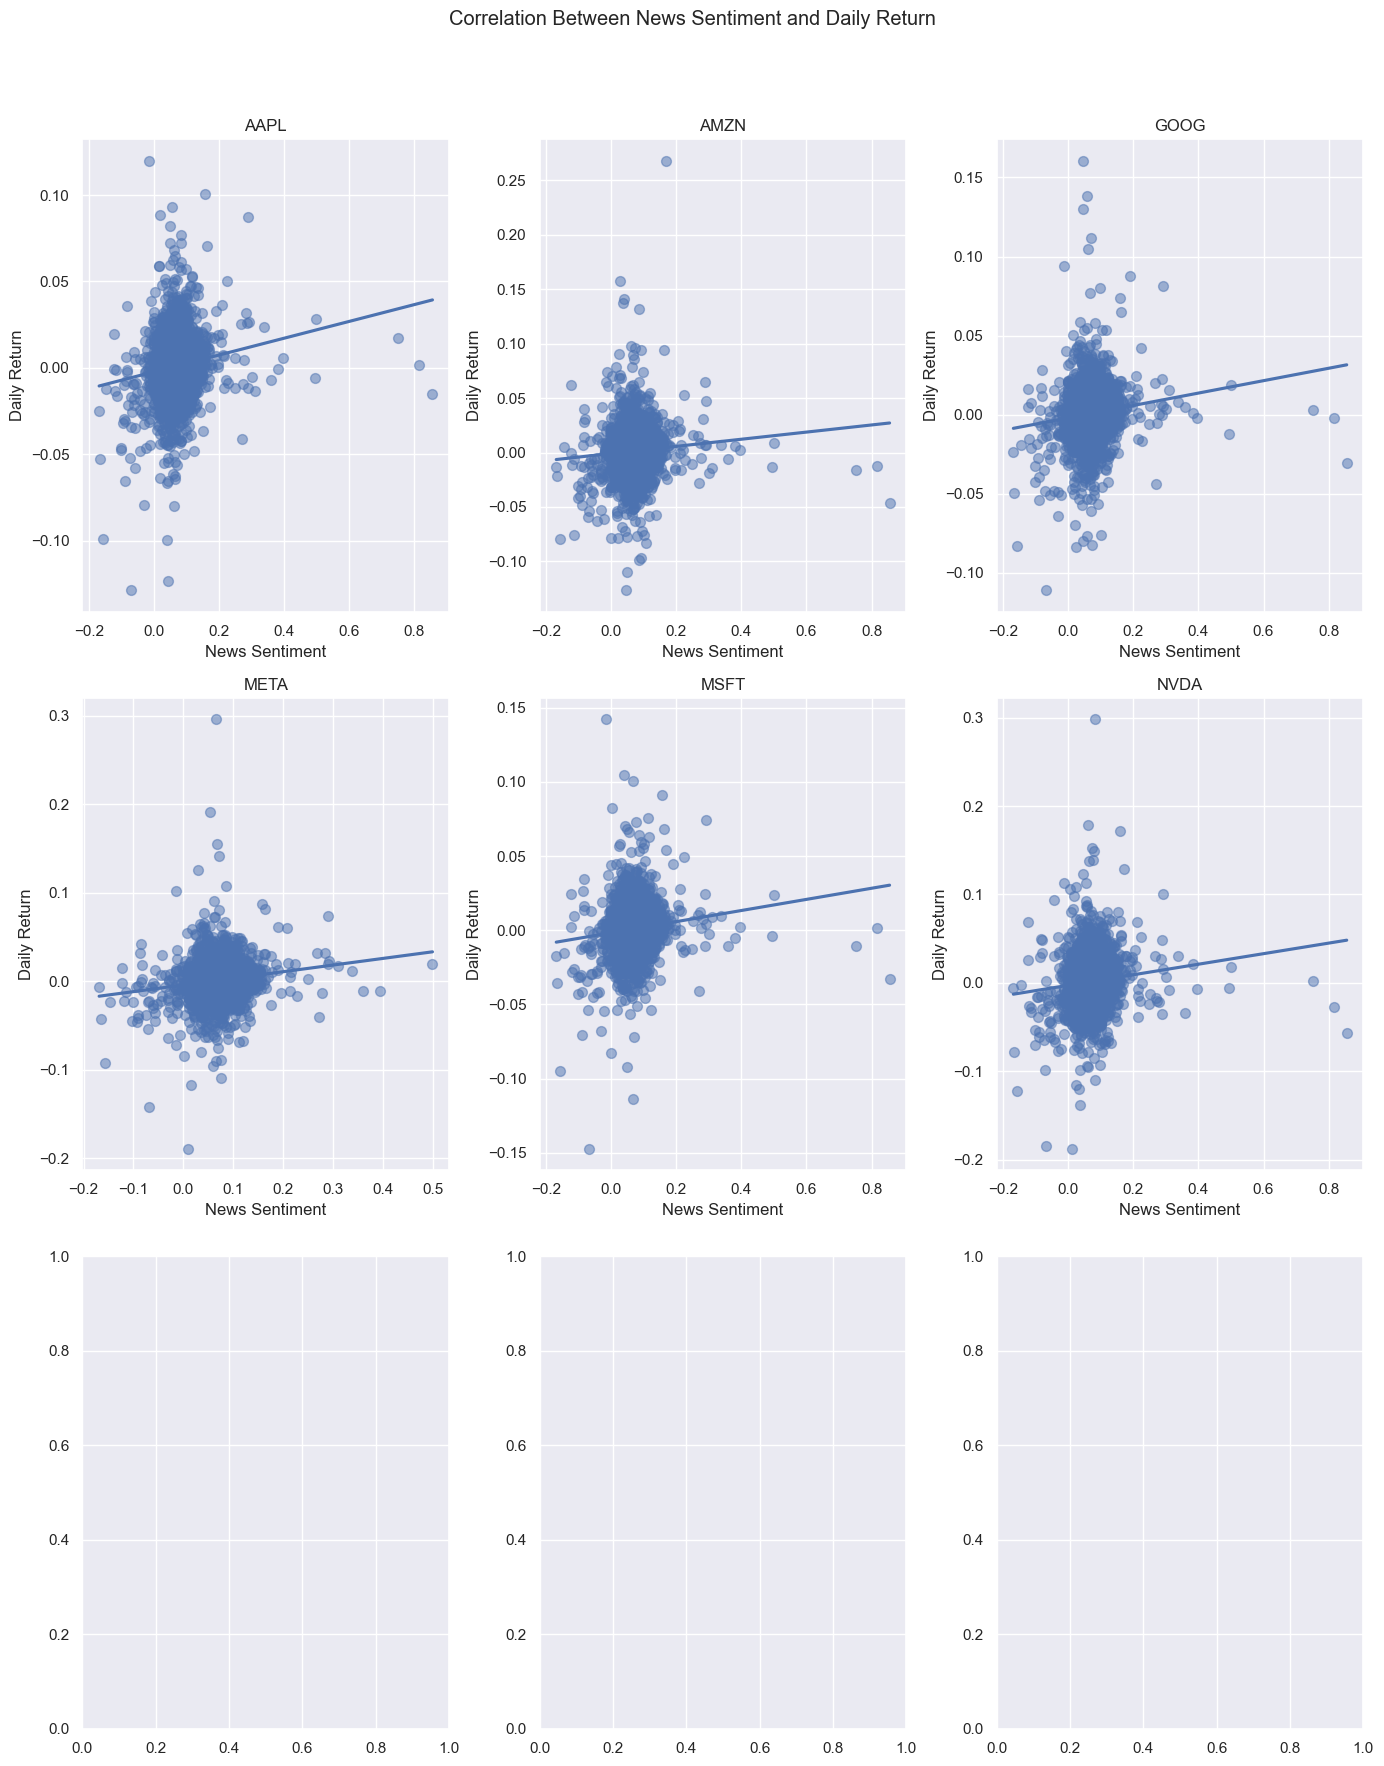

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(3, 3, figsize=(14, 18)) 
fig.suptitle('Correlation Between News Sentiment and Daily Return')

axs = axs.ravel() 

for i, (stock, data) in enumerate(all_news_merge.items()):
    sns.regplot(x=data['mean_sentiment'], y=data['daily_return'], ax=axs[i], ci=None, scatter_kws={"s": 50, "alpha": 0.5})
    axs[i].set_title(f'{stock}')
    axs[i].set_xlabel('News Sentiment')
    axs[i].set_ylabel('Daily Return')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## The plot below shows the scatter plot for the news that speak about the respective stocks against the daily returns

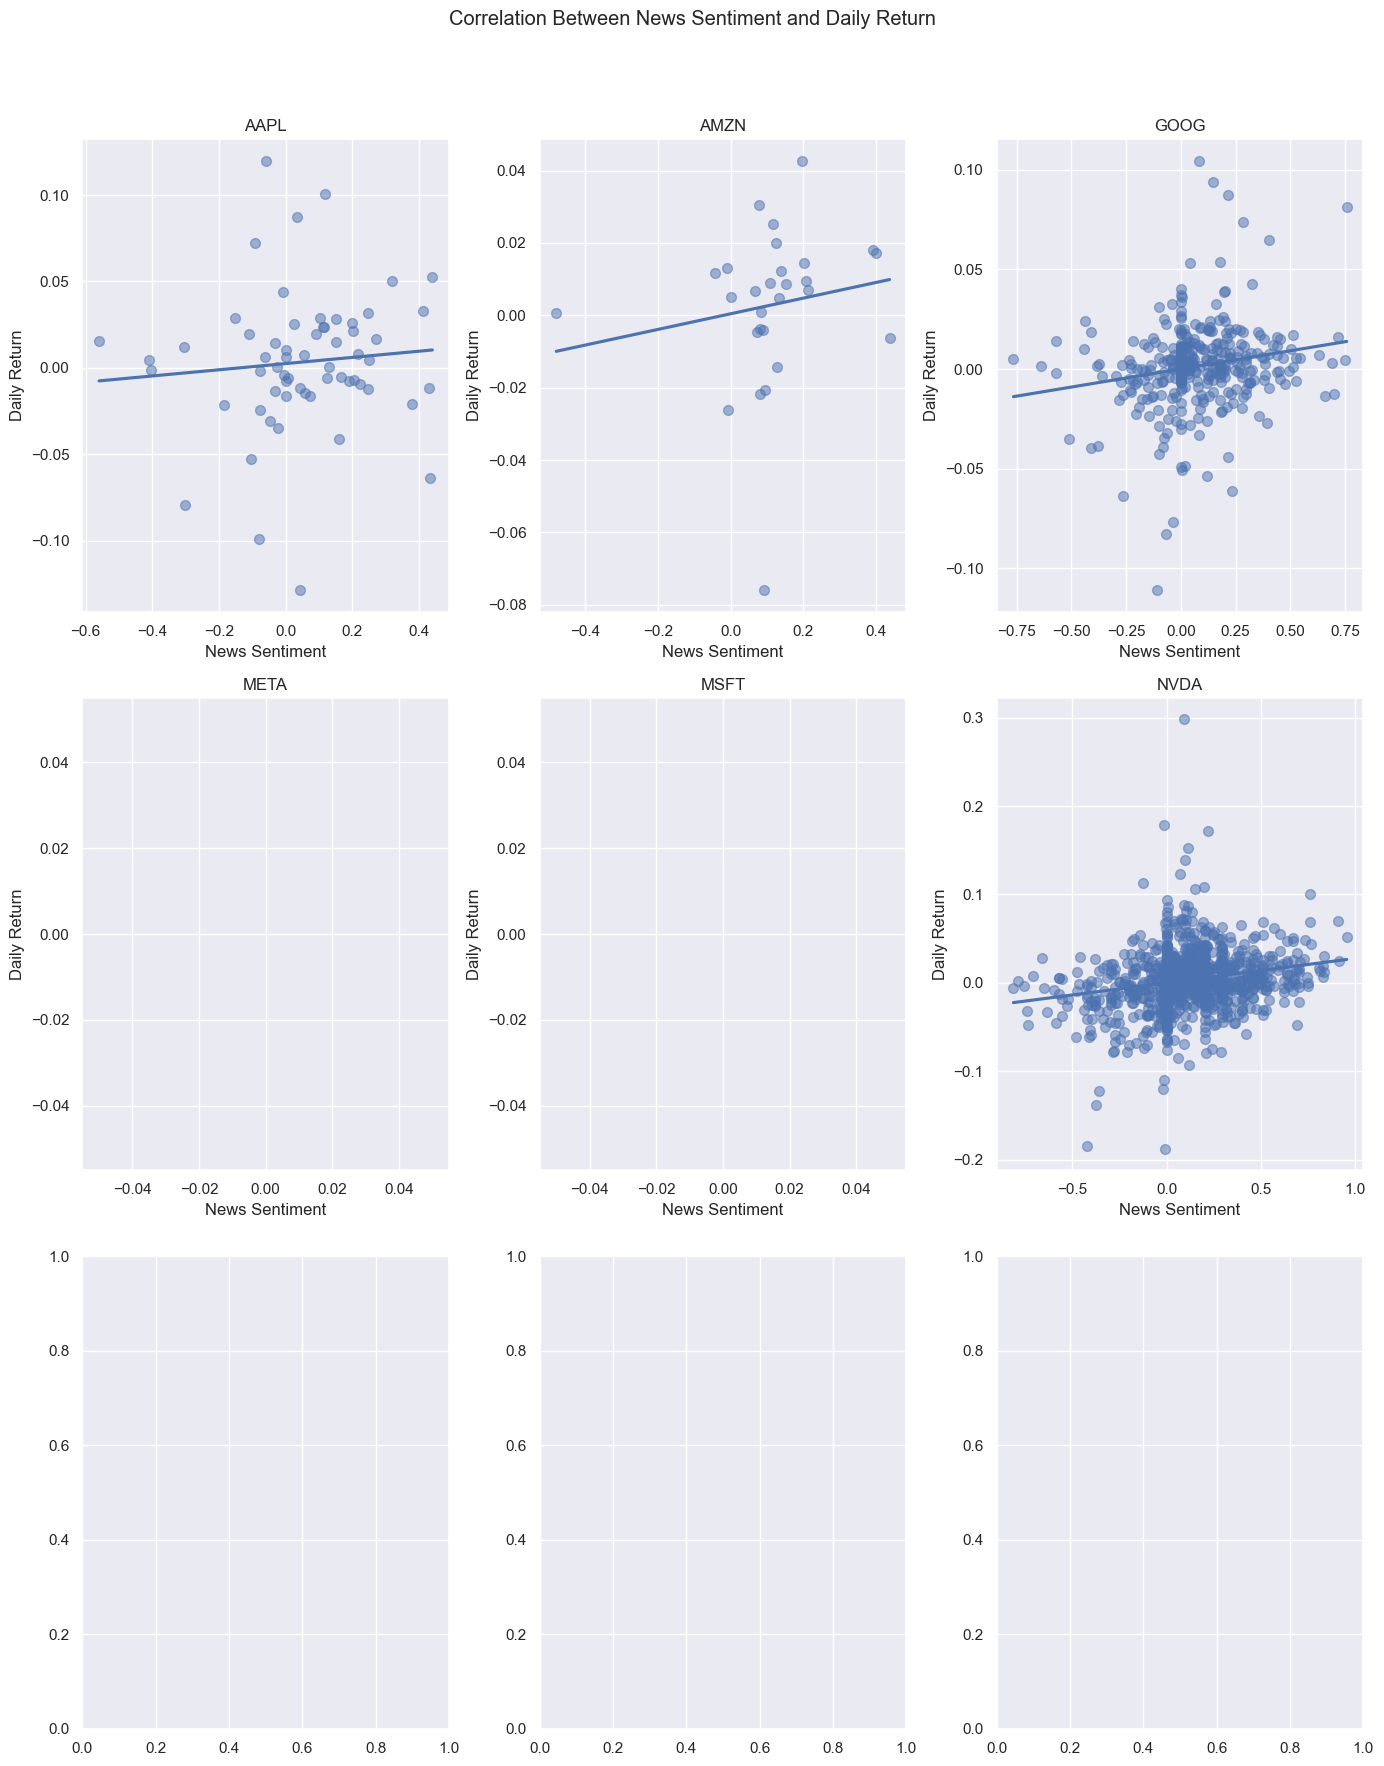

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(3, 3, figsize=(14, 18)) 
fig.suptitle('Correlation Between News Sentiment and Daily Return')

axs = axs.ravel() 

for i, (stock, data) in enumerate(respective_news_merge.items()):
    sns.regplot(x=data['mean_sentiment'], y=data['daily_return'], ax=axs[i], ci=None, scatter_kws={"s": 50, "alpha": 0.5})
    axs[i].set_title(f'{stock}')
    axs[i].set_xlabel('News Sentiment')
    axs[i].set_ylabel('Daily Return')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# The plots confirm the conclusion we made from our correlation results